In [292]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as artist
from matplotlib.patches import Circle
import functools
from math import *
import pandas as pd
import time
from IPython import display

%matplotlib inline

In [293]:
########################### case 1 ################################
# algorithm 1

# for saving plots
fignum = 0

# parameters
numNodes = 100
k = 1.2
d = 15
r = k*d
epsilon = 0.1
delta_t_update = 0.008

xAxisLowLimit = 0
xAxisHighLimit = 50
yAxisLowLimit = 0
yAxisHighLimit = 50

# generate random points
xPoints = np.random.randint(xAxisLowLimit, 
                            high = xAxisHighLimit, size=numNodes)
yPoints = np.random.randint(yAxisLowLimit, 
                            high = yAxisHighLimit, size=numNodes)

In [294]:
########################### build graph #########################

# add edge to graph (adding neighbors)
def addEdge(graph, pointIndex, neighborIndex):
    if pointIndex in graph:
        graph[pointIndex].append(neighborIndex)
    else:
        graph[pointIndex] = [neighborIndex]

def distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    return (x1-x2)**2+(y1-y2)**2

# go through all nodes to see if neighbor
def findNeighbors(nodeIndex, n, q):
    
    neighborList = []
    q_i = np.array(q[nodeIndex-1]).ravel()

    centerX, centerY = q_i[0], q_i[1]
    for j in range(nodeIndex, n):
        q_j = np.array(q[j]).ravel()
        pointX, pointY = q_j[0], q_j[1]
        if distance((centerX, centerY), (pointX, pointY)) < r**2:
            neighborList.append(j+1)
    return neighborList

# dict[node number] = [neighbors]
# nodes with neighbors
def buildGraph(n, q, adjacencyMatrix, savePlot):
    global fignum
    
    graph = dict()
    
    for i in range(1, n+1):
        centerIndex = i
        q_i = np.array(q[i-1]).ravel()
        centerX, centerY = q_i[0], q_i[1]
        neighbors = findNeighbors(centerIndex, n, q)
        for neighborIndex in neighbors:
            neighbor = neighborIndex-1
            
            q_j = np.array(q[neighbor]).ravel()
            
            pointX, pointY = q_j[0], q_j[1]
            # 3. Link sensor node with neighbor
            plt.plot([centerX, pointX], [centerY, pointY], color='b')
            # add 2 edges for undirected graph
            addEdge(graph, centerIndex, neighborIndex)
            addEdge(graph, neighborIndex, centerIndex)
            # adjacency matrix - 1 for neighbors
            # subtract 1 as for loop does 1-100
            # for node number alignment on graph
            adjacencyMatrix[centerIndex-1][neighborIndex-1] = 1
            adjacencyMatrix[neighborIndex-1][centerIndex-1] = 1
           
        if centerIndex not in graph:
            graph[centerIndex] = []
    
    if savePlot == True:
        plt.savefig(str(fignum) + '.png')
        fignum += 1
    
    return graph

def showSensorNodeGraph(x, y, n, adjacencyMatrix, savePlot):
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    plt.scatter(x, y,
                marker='>',
                color='magenta')
    # find neighbors for each node
    return buildGraph(n, q, adjacencyMatrix, savePlot)

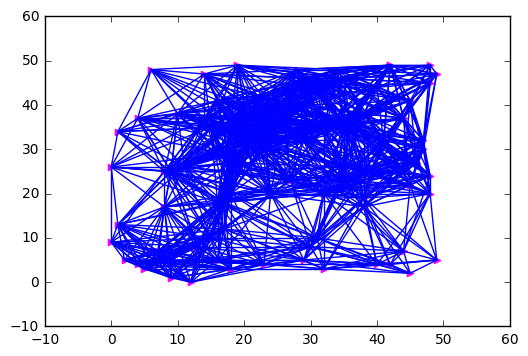

In [295]:
adjacencyMatrix = np.zeros((numNodes, numNodes))
connectivity = []

# distribute 100 random nodes in 50x50 space
nodes = showSensorNodeGraph(xPoints, yPoints, numNodes, adjacencyMatrix, False)

# connectivity = rank(adjacencyMatrix/numNodes)
rank = np.linalg.matrix_rank(adjacencyMatrix)
connectivity.append(rank/numNodes)

In [296]:
###################### Algorithm 1 #########################

# SUPPLEMENTAL FUNCTIONS

def euclideanNorm(q_i, q_j):
    return sqrt(np.sum(np.square(np.subtract(q_i, q_j))))

def sigmaNorm(z, epsilon):
    return 1/epsilon*(sqrt(1+epsilon*(z**2))-1)

# bump function
def ph(z):
    h = 0.2
    if z >= 0 and z < h:
        return 1
    elif z >= h and z < 1:
        return 0.5*(1+cos(pi*(z-h)/(1-h)))
    else:
        return 0
    
# spatial adjacency matrix
# parameter: coordinates q
def a_ij(q_i, q_j):
    h = 1
    z = euclideanNorm(q_j, q_i)
    z_alpha = sigmaNorm(z, epsilon)
    r_alpha = sigmaNorm(r, epsilon)
    result = ph(z_alpha/r_alpha)
    return result

def n_ij(q_i, q_j):
    numerator = np.subtract(q_j, q_i)
    z = euclideanNorm(q_j, q_i)
    denominator = sqrt(1+epsilon*(z**2))
    return numerator/denominator

def sigma_1(z):
    return z/sqrt(1+(z**2))

def phi(z, a, b):
    c = abs(a-b)/sqrt(4*a*b)
    return 1/2*((a+b)*sigma_1(z+c)+(a-b))

def phi_alpha(z):
    r_alpha = sigmaNorm(r, epsilon)
    d_alpha = sigmaNorm(d, epsilon)
    a = b = 5
    return ph(z/r_alpha)*phi(z-d_alpha, a, b)

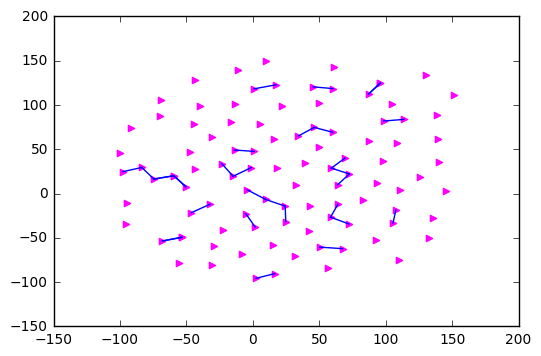

In [297]:
#################### Algorithm 1 implementation ####################

# velocity of nodes: initially all zero
# numNodes x 2 matrix
p_nodes = np.matrix(np.zeros((numNodes, 2)))

# save velocities for plotting
p_nodes_all = []
#p_nodes_all.append(p_nodes)

def u_i_alpha(nodes, q, p, i):
    c_1_alpha = 30
    c_2_alpha = 2*sqrt(c_1_alpha)
    
    q_i = q[i-1]
    p_i = p[i-1]
    
    leftTotal = np.matrix([0, 0])
    rightTotal = np.matrix([0, 0])
    
    for neighbor in nodes[i]:
        q_j = q[neighbor-1]
        p_j = p[neighbor-1]
        
        z = sigmaNorm(euclideanNorm(q_j, q_i), epsilon)
        phi_alpha_result = phi_alpha(z)
        n_ij_result = n_ij(q_i, q_j)
        leftResult = phi_alpha_result*n_ij_result
        leftTotal = np.add(leftTotal, leftResult)
        
        a_ij_result = a_ij(q_i, q_j)
        p_diff = np.subtract(p_j, p_i)
        rightResult = a_ij_result*p_diff
        rightTotal = np.add(rightTotal, rightResult)
    
    result = c_1_alpha*leftTotal + c_2_alpha*rightTotal
    return result

def p_update(q, q_old, i):
    node = q[i-1]
    node_old = q_old[i-1]
    return np.subtract(node, node_old)/delta_t_update

# update node positions
# q_i at iteration k = q_i at iteration k-1 
# + delta_t*p_i at iteration k 
# + delta_t**2/2*u_i at iteration k 
def update(u_i, q_old, p, i):
    node_old = q_old[i-1]
    p_i = p[i-1]
    u_i_i = u_i[i-1]
    result = np.add(node_old, p_i*delta_t_update)
    result = np.add(result, u_i_i*(delta_t_update**2)/2)
    return result 

def algorithm_1(nodes, n, x, y, p, iterations, connectivity, p_nodes_all):
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    # hold positions through each iteration
    q_nodes_all = []
    q_nodes_all.append(q)
    
    # list in range [1, 100]
    nodeIndex = np.arange(1, n+1, 1)
    q_old = q[:]
    
    for i in range(iterations):
        if i%20 == 0:
            savePlot = True
        else:
            savePlot = False
        
        # compute input control for nodes
        u_alpha = list(map(functools.partial(u_i_alpha, nodes, q, p), nodeIndex))
        # compute new velocities for all nodes
        p = list(map(functools.partial(p_update, q, q_old), nodeIndex))
        p_nodes_all.append(p)
    
        q_old = q[:]
        q = list(map(functools.partial(update, u_alpha, q_old, p), nodeIndex))
        q_nodes_all.append(q)
        
        # plot current positions and wait
        q_plot = np.array(q).ravel()
        x, y = q_plot[0::2], q_plot[1::2]
        
        adjacencyMatrix = np.zeros((numNodes, numNodes))
        
        nodes = showSensorNodeGraph(q_plot[0::2], q_plot[1::2], n, adjacencyMatrix, False)
        # nodes = showSensorNodeGraph(q_plot[0::2], q_plot[1::2], n, adjacencyMatrix, savePlot)
        # compute connectivity
        rank = np.linalg.matrix_rank(adjacencyMatrix)
        connectivity.append(rank/n)
        
        display.clear_output(wait=True)
        plt.show()
        time.sleep(0.01)
    return q_nodes_all

iterations = 150
q_nodes_all = algorithm_1(nodes, numNodes, xPoints, yPoints, p_nodes, iterations, connectivity, p_nodes_all)

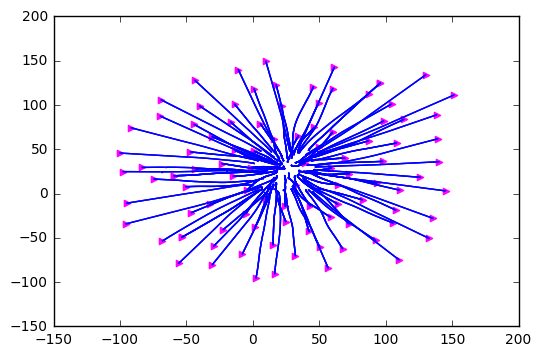

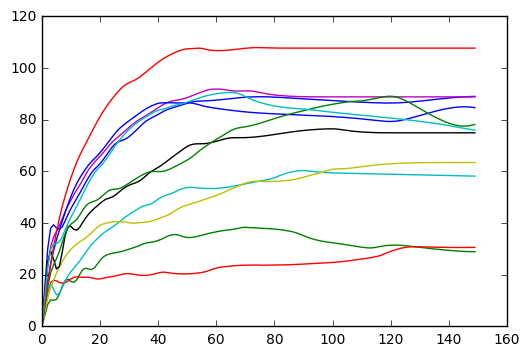

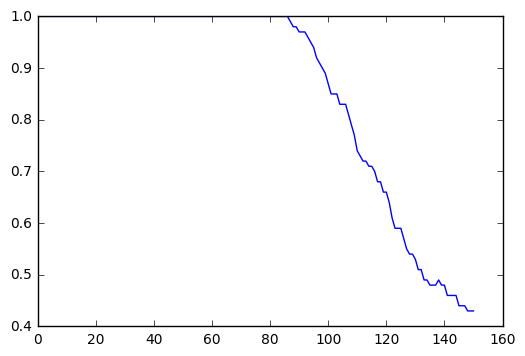

In [298]:
def plot_trajectory(q_nodes_all, n):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    q_x = []
    q_y = []

    for q_node in q_nodes_all:
        q_plot = np.array(q_node)
        q_plot = q_plot.ravel()
        x = q_plot[0::2]
        y = q_plot[1::2]
        q_x.append(list(x))
        q_y.append(list(y))

    for i in range(n):
        for j in range(len(q_nodes_all)-1):
            # connect node i at time j to node i at time j+1
            ax1.plot([q_x[j][i], q_x[j+1][i]], [q_y[j][i], q_y[j+1][i]], color='b')

    # plot last position of nodes on trajectory polot
    q_node = q_nodes_all[len(q_nodes_all)-1]
    q_plot = np.array(q_node).ravel()

    xPoints = q_plot[0::2]
    yPoints = q_plot[1::2]

    ax1.scatter(xPoints, yPoints, 
                marker='>', 
                color='magenta')

    plt.show()
    
def plot_velocity(p_nodes_all, n, numNodesToPlot):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    size = len(p_nodes_all)
    p = [np.array]*n
  
    for p_node in p_nodes_all:
        p_plot = p_node
        
        for j in range(numNodesToPlot+1):
            p[j] = np.append(p[j], np.array(np.linalg.norm(p_plot[j])))
    
    iterList = np.arange(0, size, 1)
        
    for node in range(numNodesToPlot+1):
        velocity = p[node]
        velocity = velocity[1:]
        plt.plot(iterList, velocity)
    
    plt.show()
        
def plot_connectivity(connectivity):
    nodeIndex = np.arange(0, len(connectivity), 1)
    plt.plot(nodeIndex, connectivity)
    plt.show()

plot_trajectory(q_nodes_all, numNodes)
plot_velocity(p_nodes_all, numNodes, 10)
plot_connectivity(connectivity)

In [299]:
########################### case 2 ################################
# algorithm 2

# parameters
numNodes = 100
k = 1.2
d = 15
r = k*d
epsilon = 0.1
delta_t_update = 0.008

# static target
q_mt = np.matrix([[150, 150]])
# constant because only one position for static target
q_index = 0
radius = 10

xAxisLowLimit = 50
xAxisHighLimit = 100
yAxisLowLimit = 50
yAxisHighLimit = 100

# generate random points
xPoints = np.random.randint(xAxisLowLimit, 
                            high = xAxisHighLimit, size=numNodes)
yPoints = np.random.randint(yAxisLowLimit, 
                            high = yAxisHighLimit, size=numNodes)

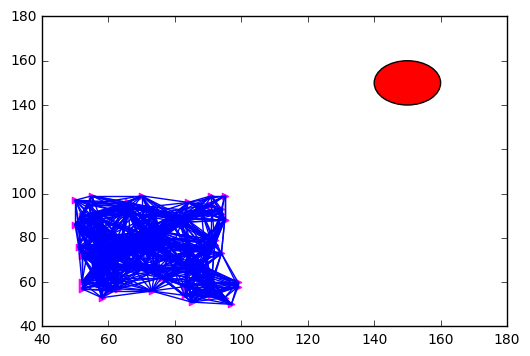

In [300]:
# plot target
def plot_target(q_mt, q_index, radius):
    fig, ax = plt.subplots()
    q_mt = np.array(q_mt[q_index]).ravel()
    centerX, centerY = q_mt[0], q_mt[1]
    circle = Circle((centerX, centerY), radius)
    circle.set_facecolor("red")
    ax.add_patch(circle)
    
adjacencyMatrix = np.zeros((numNodes, numNodes))
connectivity = []
    
# distribute 100 random nodes in 50x50 space
plot_target(q_mt, q_index, radius)
nodes = showSensorNodeGraph(xPoints, yPoints, numNodes, adjacencyMatrix, False)
plt.show()

rank = np.linalg.matrix_rank(adjacencyMatrix)
connectivity.append(rank/numNodes)

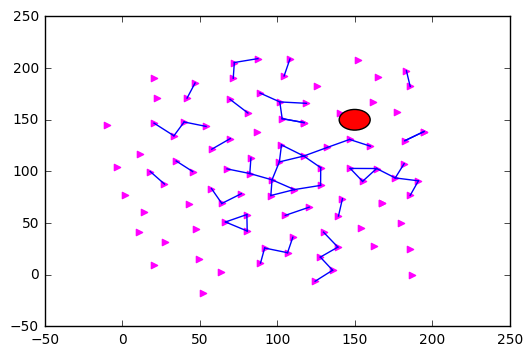

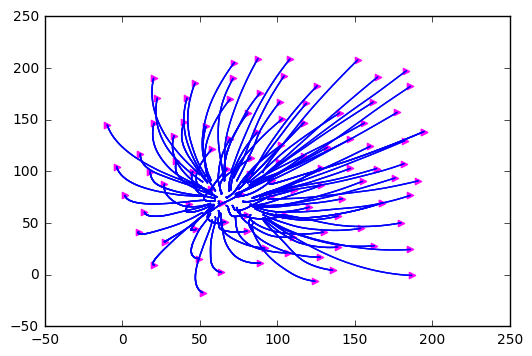

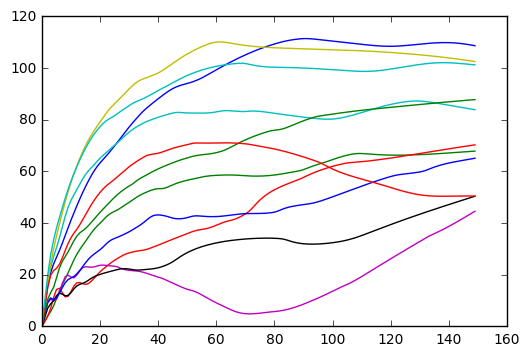

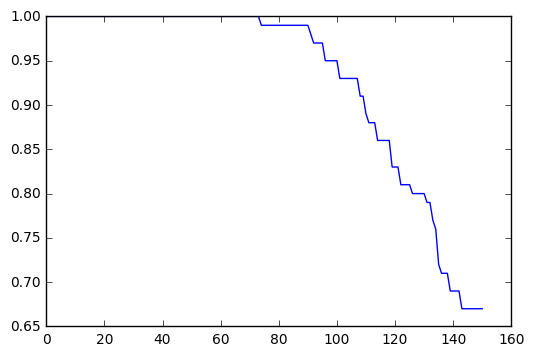

In [301]:
#################### Algorithm 2 implementation ####################
########################## Static Target ###########################

# velocity of nodes: initially all zero
# numNodes x 2 matrix
p_nodes = np.matrix(np.zeros((numNodes, 2)))

# save velocities
p_nodes_all = []
#p_nodes_all.append(p_nodes)

def u_i_static(nodes, q, i):
    global q_mt
    
    c_1_mt = 1.1
    q_i = q[i-1] 
    
    q_diff = np.subtract(q_i, q_mt)
    
    return -c_1_mt*q_diff

def algorithm_2_static(nodes, n, x, y, p, iterations, connectivity, p_nodes_all):
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    # hold positions through each iteration
    q_nodes_all = []
    q_nodes_all.append(q)
    
    # list in range [1, 100]
    nodeIndex = np.arange(1, n+1, 1)
    q_old = q[:]
    
    for i in range(iterations):
        if i%20 == 0:
            savePlot = True
        else:
            savePlot = False
        
        # compute input control for nodes
        u_alpha = list(map(functools.partial(u_i_alpha, nodes, q, p), nodeIndex))
        u_static = list(map(functools.partial(u_i_static, nodes, q), nodeIndex))
        
        u_i = np.add(u_alpha, u_static)
        # compute new velocities for all nodes
        p = list(map(functools.partial(p_update, q, q_old), nodeIndex))
        p_nodes_all.append(p)
        
        q_old = q[:]
        q = list(map(functools.partial(update, u_i, q_old, p), nodeIndex))
        q_nodes_all.append(q)
        
        # plot current positions and wait
        q_plot = np.array(q).ravel()
        x, y = q_plot[0::2], q_plot[1::2]
        
        adjacencyMatrix = np.zeros((numNodes, numNodes))
        
        plot_target(q_mt, q_index, radius)
        nodes = showSensorNodeGraph(q_plot[0::2], q_plot[1::2], n, adjacencyMatrix, False)
        # nodes = showSensorNodeGraph(q_plot[0::2], q_plot[1::2], n, adjacencyMatrix, savePlot)
       
        # compute connectivity 
        rank = np.linalg.matrix_rank(adjacencyMatrix)
        connectivity.append(rank/n)
    
        display.clear_output(wait=True)
        plt.show()
        time.sleep(0.01)
    return q_nodes_all

iterations = 150
q_nodes_all = algorithm_2_static(nodes, numNodes, xPoints, yPoints, p_nodes, iterations, connectivity, p_nodes_all)
plot_trajectory(q_nodes_all, numNodes)
plot_velocity(p_nodes_all, numNodes, 10)
plot_connectivity(connectivity)

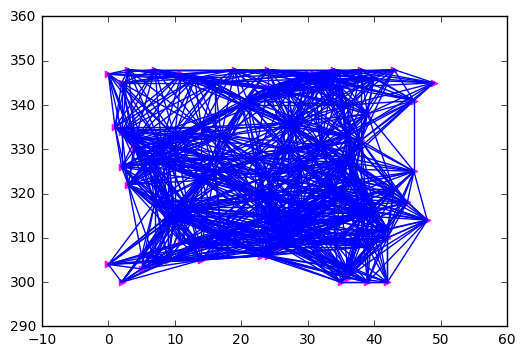

In [302]:
########################### case 3 ################################
# algorithm 2 

# parameters
numNodes = 100
k = 1.2
d = 15
r = k*d
epsilon = 0.1
delta_t_update = 0.008
iterations = 7
t = np.arange(0, iterations+1, delta_t_update)
runs = (iterations+1)/delta_t_update

xAxisLowLimit = 0
xAxisHighLimit = 50
yAxisLowLimit = 300
yAxisHighLimit = 350

# generate random points
xPoints = np.random.randint(xAxisLowLimit, 
                            high = xAxisHighLimit, size=numNodes)
yPoints = np.random.randint(yAxisLowLimit, 
                            high = yAxisHighLimit, size=numNodes)

adjacencyMatrix = np.zeros((numNodes, numNodes))
connectivity = []

# distribute 100 random nodes in 50x50 space
nodes = showSensorNodeGraph(xPoints, yPoints, numNodes, adjacencyMatrix, False)

rank = np.linalg.matrix_rank(adjacencyMatrix)
connectivity.append(rank/numNodes)

In [303]:
################ Compute Target Position/Velocity #################

# radius of target
radius = 5

# target position
# sine wave trajectory
def qt_x1(t):
    return 50+50*t

def qt_y1(t):
    return 295-50*sin(t)

q_mt_x = list(map(qt_x1, t))
q_mt_y = list(map(qt_y1, t))

q_mt = np.column_stack((q_mt_x, q_mt_y))
q_mt = list(map(np.matrix, q_mt))

# target velocity
p_mt = []
p_mt.append(np.matrix([0, 0]))
for i in range(1, len(q_mt)):
    velocity = np.subtract(q_mt[i], q_mt[i-1])/delta_t_update
    p_mt.append(velocity)

In [304]:
###################### SUPPLEMENTAL FUNCTION ########################

# compute center of mass
def plot_COM(q_nodes_all, n):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    q_mean_x = []
    q_mean_y = []
    
    for q_node in q_nodes_all:
        q_plot = np.array(q_node).ravel()
        x = q_plot[0::2]
        y = q_plot[1::2]
        q_mean_x.append(np.mean(x))
        q_mean_y.append(np.mean(y))
    
    plt.plot(q_mean_x, q_mean_y)
    plt.plot(q_mt_x, q_mt_y)
    plt.show()

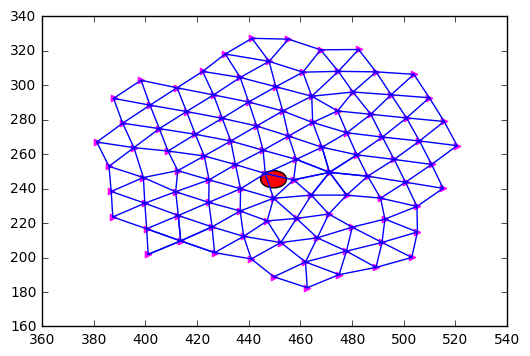

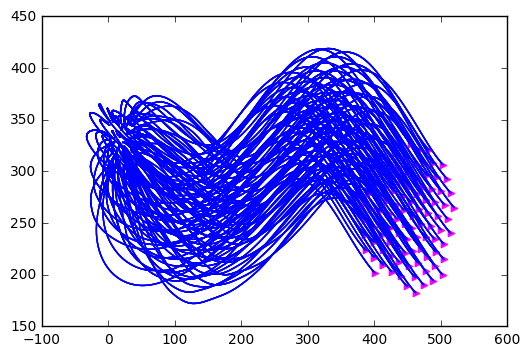

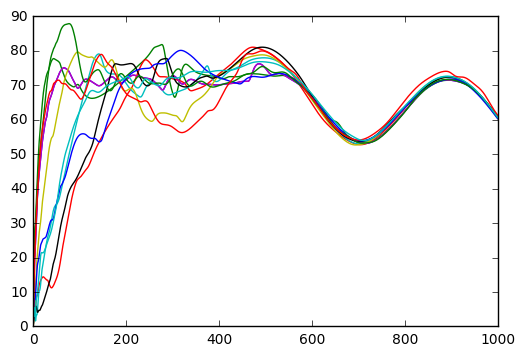

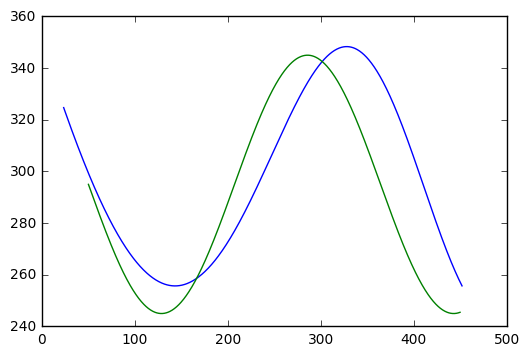

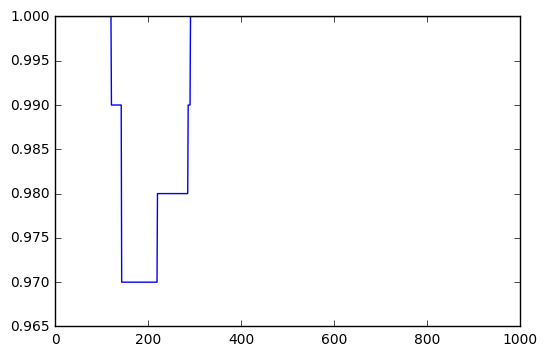

In [305]:
#################### Algorithm 2 implementation ####################
########################## Dynamic Target ###########################
###################### Sine Wave Trajectory #######################

# velocity of nodes: initially all zero
# numNodes x 2 matrix
p_nodes = np.matrix(np.zeros((numNodes, 2)))

p_nodes_all = []
#p_nodes_all.append(p_nodes)

def u_i_dynamic(nodes, q, p, q_mt_t, p_mt_t, i):
    c_1_mt = 1.1
    c_2_mt = 2*sqrt(c_1_mt)
    
    q_i = q[i-1] 
    p_i = p[i-1]
    
    q_diff = -c_1_mt*np.subtract(q_i, q_mt_t)
    p_diff = -c_2_mt*np.subtract(p_i, p_mt_t)
    
    return np.add(q_diff, p_diff)

def algorithm_2_dynamic(nodes, n, x, y, p, connectivity, p_nodes_all):
    # all positions/velocities of moving target
    global q_mt
    global p_mt
    # number of steps to run algorithm
    global runs
    
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    # hold positions through each iteration
    q_nodes_all = []
    q_nodes_all.append(q)
    
    # list in range [1, 100]
    nodeIndex = np.arange(1, n+1, 1)
    q_old = q[:]
    
    for i in range(int(runs)):
        if i%50 == 0:
            savePlot = True
        else:
            savePlot = False
        
        # current position of dynamic target
        q_mt_t = q_mt[i]
        p_mt_t = p_mt[i]
        
        # compute input control for nodes
        u_alpha = list(map(functools.partial(u_i_alpha, nodes, q, p), nodeIndex))
        u_dynamic = list(map(functools.partial(u_i_dynamic, nodes, q, p, q_mt_t, p_mt_t), nodeIndex))
        
        u_i = np.add(u_alpha, u_dynamic)
        # compute new velocities for all nodes
        p = list(map(functools.partial(p_update, q, q_old), nodeIndex))
        p_nodes_all.append(p)
        
        q_old = q[:]
        q = list(map(functools.partial(update, u_i, q_old, p), nodeIndex))
        q_nodes_all.append(q)
        
        # plot current positions and wait
        q_plot = np.array(q).ravel()
        x, y = q_plot[0::2], q_plot[1::2]
        
        adjacencyMatrix = np.zeros((numNodes, numNodes))
        
        plot_target(q_mt, i, radius)
        
        nodes = showSensorNodeGraph(x, y, n, adjacencyMatrix, False)
        # nodes = showSensorNodeGraph(x, y, n, adjacencyMatrix, savePlot)
        
        rank = np.linalg.matrix_rank(adjacencyMatrix)
        connectivity.append(rank/numNodes)
        
        display.clear_output(wait=True)
        plt.show()
        time.sleep(0.01)
    return q_nodes_all

q_nodes_all = algorithm_2_dynamic(nodes, numNodes, xPoints, yPoints, p_nodes, connectivity, p_nodes_all)
plot_trajectory(q_nodes_all, numNodes)
plot_velocity(p_nodes_all, numNodes, 10)
plot_COM(q_nodes_all, numNodes)
plot_connectivity(connectivity)

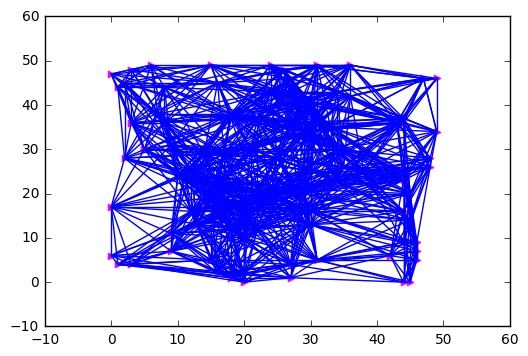

In [306]:
########################### case 4 ################################
# algorithm 2 

# parameters
numNodes = 100
k = 1.2
d = 15
r = k*d
epsilon = 0.1
delta_t_update = 0.008
iterations = 7
t = np.arange(0, iterations+1, delta_t_update)
runs = (iterations+1)/delta_t_update

xAxisLowLimit = 0
xAxisHighLimit = 50
yAxisLowLimit = 0
yAxisHighLimit = 50

# generate random points
xPoints = np.random.randint(xAxisLowLimit, 
                            high = xAxisHighLimit, size=numNodes)
yPoints = np.random.randint(yAxisLowLimit, 
                            high = yAxisHighLimit, size=numNodes)

adjacencyMatrix = np.zeros((numNodes, numNodes))
connectivity = []

# distribute 100 random nodes in 50x50 space
nodes = showSensorNodeGraph(xPoints, yPoints, numNodes, adjacencyMatrix, False)

rank = np.linalg.matrix_rank(adjacencyMatrix)
connectivity.append(rank/numNodes)

In [ ]:
################ Compute Target Position/Velocity #################

# radius of target
radius = 10

# target position
# circle trajectory
def qt_x1(t):
    return 310-160*cos(t)

def qt_y1(t):
    return 255-160*sin(t)

q_mt_x = list(map(qt_x1, t))
q_mt_y = list(map(qt_y1, t))

q_mt = np.column_stack((q_mt_x, q_mt_y))
q_mt = list(map(np.matrix, q_mt))

# target velocity
p_mt = []
p_mt.append(np.matrix([0, 0]))
for i in range(1, len(q_mt)):
    velocity = np.subtract(q_mt[i], q_mt[i-1])/delta_t_update
    p_mt.append(velocity)

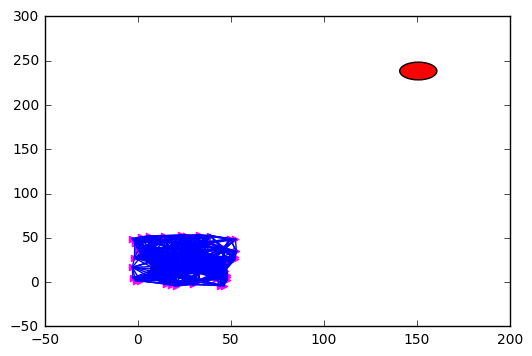

In [ ]:
#################### Algorithm 2 implementation ####################
########################## Dynamic Target ###########################
###################### Circle Trajectory #######################

# velocity of nodes: initially all zero
# numNodes x 2 matrix
p_nodes = np.matrix(np.zeros((numNodes, 2)))

p_nodes_all = []
#p_nodes_all.append(p_nodes)

q_nodes_all = algorithm_2_dynamic(nodes, numNodes, xPoints, yPoints, p_nodes, connectivity, p_nodes_all)
plot_trajectory(q_nodes_all, numNodes)
plot_COM(q_nodes_all, numNodes)
plot_velocity(p_nodes_all, numNodes, 10)
plot_connectivity(connectivity)